
# Speech recognition


### Типичная структура системы распознавания речи 

   **Распознавание речи** — это многоуровневая задача распознавания образов, в которой акустические сигналы анализируются и структурируются в иерархию структурных элементов (например, фонем, слов, фраз и предложений). 

Каждый уровень иерархии может предусматривать некоторые временные константы, например, возможные последовательности слов или известные виды произношения, которые позволяют уменьшить количество ошибок распознавания на более низком уровне. Чем больше мы знаем (или предполагаем) априорной информации о входном сигнале, тем качественнее мы можем его обработать и распознать.

Структура стандартной системы распознавания речи показана на рисунке.
![Схема](http://masters.donntu.org/2011/fknt/shatokhin/diss/scheme_rus.jpg "Схема")
Рассмотрим основные элементы этой системы.

* ***Необработанная речь***. Обычно, поток звуковых данных, записанный с высокой дискретизацией (20 КГц при записи с микрофона либо 8 КГц при записи с телефонной линии). 


* ***Анализ сигнала***. Поступающий сигнал должен быть изначально трансформирован и сжат, для облегчения последующей обработки. Есть различные методы для извлечения полезных параметров и сжатия исходных данных в десятки раз без потери полезной информации. Наиболее используемые методы:

    * анализ Фурье;
    * линейное предсказание речи;
    * кепстральный анализ.


* ***Речевые кадры***. Результатом анализа сигнала является последовательность речевых кадров. Обычно, каждый речевой кадр – это результат анализа сигнала на небольшом отрезке времени (порядка 10 мс.), содержащий информацию об этом участке (порядка 20 коэффициентов). Для улучшения качества распознавания, в кадры может быть добавлена информация о первой или второй производной значений их коэффициентов для описания динамики изменения речи.


* ***Акустические модели***. Для анализа состава речевых кадров требуется набор акустических моделей. Рассмотрим две наиболее распространенные из них.
    * *Шаблонная модель*. В качестве акустической модели выступает каким-либо образом сохраненный пример распознаваемой структурной единицы (слова, команды). Вариативность распознавания такой моделью достигается путем сохранения различных вариантов произношения одного и того же элемента (множество дикторов много раз повторяют одну и ту же команду). Используется, в основном, для распознавания слов как единого целого (командные системы).
    * *Модель состояний*. Каждое слово моделируется как последовательность состояний указывающих набор звуков, которые возможно услышать в данном участке слова, основываясь на вероятностных правилах. Этот подход используется в более масштабных системах.
    
    
* ***Акустический анализ***. Состоит в сопоставлении различных акустических моделей к каждому кадру речи и выдает матрицу сопоставления последовательности кадров и множества акустических моделей. Для шаблонной модели, эта матрица представляет собой Евклидово расстояние между шаблонным и распознаваемым кадром (т.е. вычисляется, как сильно отлечается полученный сигнал от записанного шаблона и находится шаблон, который больше всего подходит полученному сигналу). Для моделей, основанных на состоянии, матрица состоит из вероятностей того, что данное состояние может сгенерировать данный кадр.


* ***Корректировка времени***. Используется для обработки временной вариативности, возникающей при произношении слов (например, “растягивание” или “съедание” звуков).


* ***Последовательность слов***. В результате работы, система распознавания речи выдает последовательность (или несколько возможных последовательностей) слов, которая, наиболее вероятно, соответствует входному потоку речи.


 Теперь воспользуемся несколькими библоитками для Python, визуализируем звуковую дорожку и посмотрим как же извлекается "смысл".

### Построение осциллограммы звука из .wav-файла

Для разбора звука изпользуется библиотека **numpy**, а для построения графика — **matplotlib**.

In [4]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math



 Рассмотрим основы работы с wav-файлами и алгоритм скрипта.

*UPD1: коэффициент прореживания k лучше брать примерно k = nframes/w/32, подобрано эмпирически.*  

[WAV](https://en.wikipedia.org/wiki/WAV) — это формат для хранения несжатого аудиопотока, широко используемый в медиаиндустрии. 

Его особенность в том, что для кодирования амплитуды выделяется фиксированное число бит. Это сказывается на размере выходного файла, но делает его очень удобным для чтения. Типичный wave-файл состоит из заголовочной части, тела с аудиопотоком и хвоста для дополнительной информации, куда аудиоредакторы могут записывать собственные метаданные.

Из заголовочной части извлекаются основные параметры:
* число каналов - это 
* битрейт -  это
* число фреймов — это
На основе этих параметром осуществляется разбор аудиопотока. 
 
Wave-файл хранит в себе 1 или 2 канала, каждый из которых кодируется 8, 16, 24 или 32 битами. 
 
 Последовательность бит, описывающая амплитуду волны в момент времени, называется ***сэмплом***. 
 Последовательность сэмплов для всех каналов в определенный момент называется ***фреймом***.

Например, **\xe2\xff\xe3\xfа** — это фрейм 16-битного wav-файла. Значит, **\xe2\xff** — сэмпл первого (левого) канала, а **\xe3\xfа** — второго (правого). Сэмплы представляют собой целые знаковые числа (исключение — файлы с сэмплами в 8 бит, беззнаковые числа).

Библиотека [wave](https://docs.python.org/3/library/wave.html) предназначена для парсинга wav-файлов. Она позволяет получить основные характеристики звука и читать его по отдельным фреймам.

In [5]:
# не забудьте вписать имя файла
import wave
wav = wave.open(".//wav_files//FILE.wav", mode="r")
(nchannels, sampwidth, framerate, nframes, comptype, compname) = wav.getparams()
content = wav.readframes(nframes)

Этими строками мы создаем объект для чтения wav-файла (если параметр «r» опустить, то будет создан объект для записи, что нам не подходит). Метод ***getparams()*** возвращает кортеж основных параметров файла (по порядку): 
* число каналов
* число байт на сэмпл 
* число вреймов в секунду 
* общее число фреймов
* тип сжатия 
* имя типа сжатия. 
Вынесем их в отдельные переменные для удобного обращения.

Метод ***readframes()*** считывает указанное число фреймов относительно внутреннего указателя объекта и инкрементирует его. В данном случае, мы за один раз считали все фреймы в одну байтовую строку в переменную content.

Теперь нужно разобрать эту строку. Параметр ***sampwidth*** определяет, сколько байт уходит на кодирование одного сэмпла:
* 1 = 8 бит, беззнаковое целое (0-255),
* 2 = 16 бит, знаковое целое (-32768-32767),
* 4 = 32 бит, знаковое длинное целое (-2147483648-2147483647).

Разбор осуществляется следующим образом:

Создайте словарь, ключи в котором числа 1,2,4, а значения переменные типа int8, int16, int32 из библиотеки ***numpy*** 

In [6]:
types = #ваш код здесь

samples = np.fromstring(content, dtype=types[sampwidth])

Здесь задействуется библиотека **numpy**. Ее основное предназначение — математические действия с массивами и матрицами. **Numpy** оперирует своими собственными типами данных. Функция **fromstring()** создает одномерный массив из байтовой строки, при этом параметр **dtype** определяет, как будут интерпретированы элементы массива. В нашем примере, тип данных берется из словаря **types**, в котором сопоставлены размеры сэмпла и типы данных **numpy**.

Теперь у нас есть массив сэмплов аудиопотока. Если в нем один канал, весь массив будет представлять его, если два (или несколько), то нужно «проредить» массив, выбрав для каждого канала каждый n-ый элемент:


In [7]:
for n in range(nchannels):
    channel = samples[n::nchannels]


В этом цикле в массив **channel** выбирается каждый аудиоканал при помощи среза вида **[offset::n]**, где **offset** — индекс первого элемента, а **n** — шаг выборки. Но массив канала содержит огромное количество точек, и вывод графика для 3-минутного файла потребует огромных затрат памяти и времени. Введем в код некоторые дополнительные переменные:

In [8]:
duration = nframes / framerate 
w, h = 800, 300
DPI = 72
peak = 256 ** sampwidth / 2
k = nframes/w/32

* **duration** — длительность потока в секундах
* **w** и **h** — ширина и высота выходного изображения
* **DPI** — произвольное значение, необходимое для перевода пикселей в дюймы
* **peak** — пиковое значение амплитуды сэмпла
* **k** — коэффициент прореживания канала, зависящий от ширины изображения; подобран эмпирически.

Скорректируем отображение графика:

In [9]:
plt.figure(1, figsize=(float(w)/DPI, float(h)/DPI), dpi=DPI)
plt.subplots_adjust(wspace=0, hspace=0)

**format_time** и **format_db** — это функции для форматирования значений шкал осей абсцисс и ординат.

**format_time** форматирует время по номеру сэмпла:

In [12]:
def format_time(x, pos=None):
    global duration, nframes, k
    progress = int(x / float(nframes) * duration * k)
    mins, secs = divmod(progress, 60)
    hours, mins = divmod(mins, 60)
    out = "%d:%02d" % (mins, secs)
    if hours > 0:
        out = "%d:" % hours
    return out

Функция **format_db** форматирует громкость звука по его амплитуде:

In [13]:
def format_db(x, pos=None):
    if pos == 0:
        return ""
    global peak
    if x == 0:
        return "-inf"

    db = 20 * math.log10(abs(x) / float(peak))
    return int(db)

Теперь цикл с выводом каналов будет выглядеть так:

In [14]:
for n in range(nchannels):
    channel = samples[n::nchannels]

    channel = channel[0::int(k)]
    if nchannels == 1:
        channel = channel - peak

    axes = plt.subplot(2, 1, n+1, axisbg="k")
    axes.plot(channel, "g")
    axes.yaxis.set_major_formatter(ticker.FuncFormatter(format_db))
    plt.grid(True, color="w")
    axes.xaxis.set_major_formatter(ticker.NullFormatter())

C:\Users\Sema\AppData\Roaming\Python\Python36\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\Sema\AppData\Roaming\Python\Python36\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


В цикле делается проверка на число каналов. Как известно, 8-битный звук хранится в беззнаковых целых, поэтому его необходимо нормализовать, отняв от каждого сэмпла половину амплитуды.

Напоследок, установим формат нижней оси 

Сохраним график в картинку и покажем его:

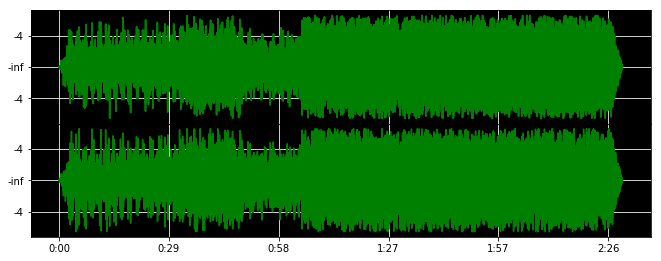

In [15]:
axes.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
plt.savefig("wave", dpi=DPI)
plt.show()

Полная версия скрипта:

C:\Users\Sema\AppData\Roaming\Python\Python36\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


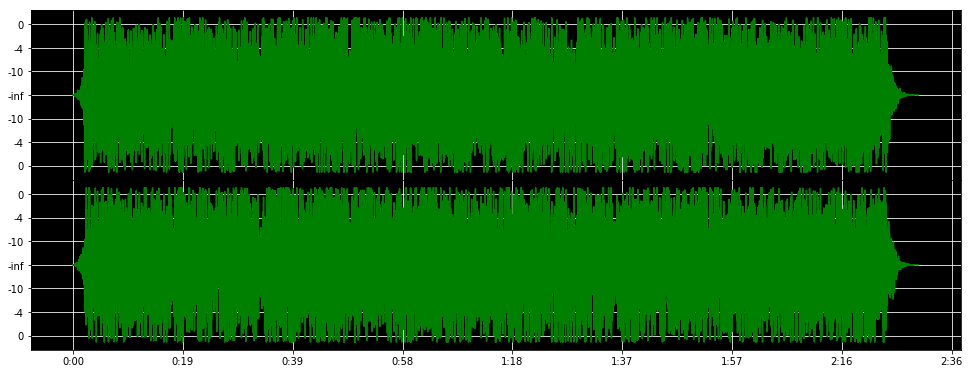

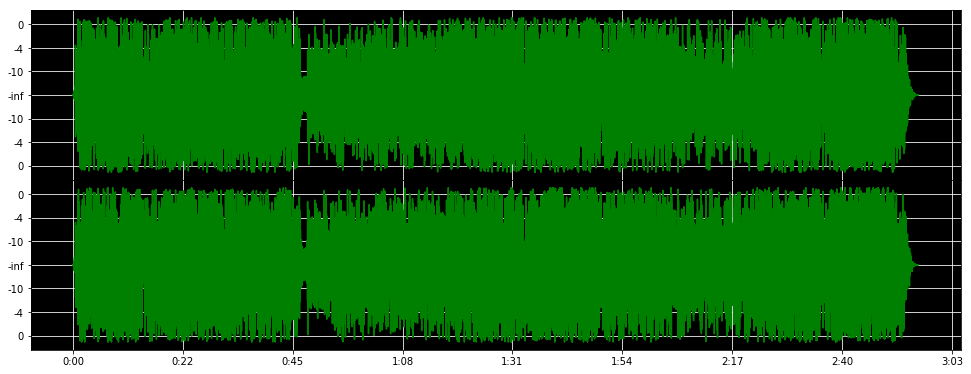

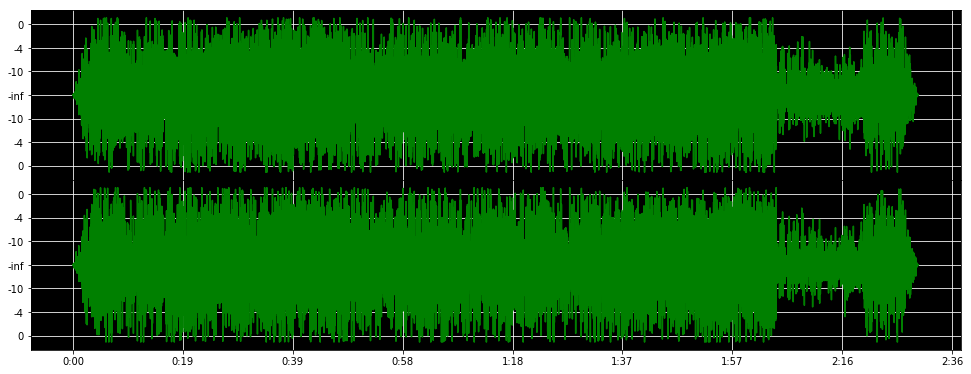

In [21]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

types = {#ваш код
}

def format_time(x, pos=None):
    global duration, nframes, k
    progress = int(x / float(nframes) * duration * k)
    mins, secs = divmod(progress, 60)
    hours, mins = divmod(mins, 60)
    out = "%d:%02d" % (mins, secs)
    if hours > 0:
        out = "%d:" % hours
    return out

def format_db(x, pos=None):
    if pos == 0:
        return ""
    global peak
    if x == 0:
        return "-inf"

    db = 20 * math.log10(abs(x) / float(peak))
    return int(db)

for i in ['Radio_Record_-_Alan_Walker_-_Sing_Me_To_Sleep_Miki.wav', 
          'Radio_Record_-_Julian_Perretta-Miracle_DJ_Amice_Re.wav',
          'Radio_Record-Calvin_Harris_feat_Rihanna_-_This_Is_.wav']:
    wav = wave.open('.//wav_files//'+str(i), mode="r")
    (nchannels, sampwidth, framerate, nframes, comptype, compname) = wav.getparams()

    duration = nframes / framerate
    w, h = 1200, 450
    k = nframes/w/16 #проряженность графика
    DPI = 72
    peak = 256 ** sampwidth / 2

    content = wav.readframes(nframes)
    samples = np.fromstring(content, dtype=types[sampwidth])

    plt.figure(1, figsize=(float(w)/DPI, float(h)/DPI), dpi=DPI)
    plt.subplots_adjust(wspace=0, hspace=0)

    for n in range(nchannels):
        channel = samples[n::nchannels]

        channel = channel[0::int(k)]
        if nchannels == 1:
            channel = channel - peak

        axes = plt.subplot(2, 1, n+1, axisbg="k")
        axes.plot(channel, "g")
        axes.yaxis.set_major_formatter(ticker.FuncFormatter(format_db))
        plt.grid(True, color="w")
        axes.xaxis.set_major_formatter(ticker.NullFormatter())

    axes.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
    plt.savefig("wave", dpi=DPI)
    plt.show()

### Этапы преобразования звука в текст

Возвращаясь к автоматической обработке речи, стоит отметить, что на совремнном этапе развития технологий основную вычислительную задачу выполняют модели глубокого обучения - нейронные сети. Однако отметим, что прежде всего данные необходимо должным образом подготовить, то есть провести предобработку. В качестве примера создания подобной модели приведем общий алгоритм действий, используемый в крупных компания (Google, Яндекс).

1. **Предобработка**. Мы дробим звуковую запись на фреймы по 25 мс с шагом 10 мс. (Возможно, также стараемся некоторыми методами избавиться от шума.)
2. **Извлечение фичей**. Из каждого фрейма извлекаются некоторые численные фичи.
3. **Преобразование фичей в распределение по фонемам** (на самом деле в реальной модели не фонемы, а сеноны — классы контекстно-зависимых фонем). Фичи от нескольких соседних фреймов соединяются вместе, и на это добро натравливается некоторая нейронная сеть (DNN, LSTM, GRU — что душе угодно). На выходе мы получаем вероятностное распределение по фонемам.
4. **Декодирование**. Далее с учетом языковой модели, лексикона и нашего представления о мире происходит декодирование найденных распределений вероятностей, и мы получаем цепочку слов.

### Создание диалогово-ассистирующей системы

Так как реализация моделей автоматического распознавания речи процесс длителный и весьма трудоемкий. Укажем по крайней мере две причины:
* наличие релевантного корпуса звуковых файлов и "верные" транскрипции
* наличие большого количества вычислительных мощностей 

Поэтому для создания чат-бота, как примера распознования и генерации письменной и устной речи буду испльзоваться предобученные модели.
В первую очередь необхоходимо импортировать необходимые библиотеки.

In [11]:
#!/usr/bin/env python3
import speech_recognition as sr
import chatterbot
from chatterbot import ChatBot
from chatterbot.trainers import ChatterBotCorpusTrainer
from gtts import gTTS
import os
import time
import playsound
import random
from time import ctime
import mutagen
from mutagen.mp3 import MP3
import webbrowser

В качестве модели генерации письменной речи используется библиотека ***chatterbot***, которая позволяет создать "собеседника" и самостоятельно обучить любым репликам. 
В данном случае, создаем объект и даем ему имя ***ChatBot("Sem")***, затем скачиваем готовые диалоговые корпуса и тренируем на них созданного чат-бота.
Корпуса включают набор дилогов на английском языке на разнообразные темы. Список их будет вывевед на этапе тренировки.
Запустим ее применим методом ***.train()*** к сужествующему ***chatterbot*** и передадим в ему название корпуса ***"chatterbot.corpus.english"***

In [13]:
chatterbot = ChatBot("Sem")
chatterbot.set_trainer(ChatterBotCorpusTrainer)
#ваш код десь

ai.yml Training: [####################] 100%
botprofile.yml Training: [####################] 100%
computers.yml Training: [####################] 100%
conversations.yml Training: [####################] 100%
drugs.yml Training: [####################] 100%
emotion.yml Training: [####################] 100%
food.yml Training: [####################] 100%
gossip.yml Training: [####################] 100%
greetings.yml Training: [####################] 100%
history.yml Training: [####################] 100%
humor.yml Training: [####################] 100%
literature.yml Training: [####################] 100%
money.yml Training: [####################] 100%
movies.yml Training: [####################] 100%
politics.yml Training: [####################] 100%
psychology.yml Training: [####################] 100%
science.yml Training: [####################] 100%
sports.yml Training: [####################] 100%
trivia.yml Training: [####################] 100%


И сразу создадим функцию, которая будет получать ответ от чат-бота.
Для этого воспользуемся методом ***.get_response()***, на забудем подаь на вход реплику на которую ожидаем ответ. Желательно ее также выводить, для проверки точности проговаривания.

In [4]:
def response(text): 
    #ваш код здесь

Для "превращения" текста в речи используем модуль ***gTTS*** - google text-to-speech.
Сохраним полученный результат методом ***.save()***, примененным к объекту, и не забудем его воспроизвести с помощью ***.playsound()*** из одноименной библиотеки.
"Обернем" эту все в функцию для удобства.

P.S.: random используется во избежании ошибки "прав" при воспроизведении

In [8]:
def speak(text):
    tts = gTTS(text=text, lang='en')
    i = random.randint(10,10000)
    tts.save(".//voice_records//sound"+str(i)+".mp3")
    playsound.playsound(".//voice_records//sound"+str(i)+".mp3", True)

Следом создадим главную функцию, которая и будет отвечать за распознавание речи. Будем использовать библиотеку ***speech recognition***. У нее неплохой функционал, который позволяет создать API к Google Speech Recognition, Sphinx.
Также укажем действия, исполняемые при появлении ошибок разного рода.
* r - объект для распознавания
* source - объект, производящий запись - микрофон

Вам необходимо создать переменную ***audio***, которая я вляется результатом применения метода ***.record()*** к объеку ***r*** и передать ему источник (***source***), а также огриничить длительность записи ***duration=***  десятью секундами, к примеру.

Также сохдаем пременную ***text***  - метод ***.recognize_google()*** к ***r*** и не збудем передать в него наш звуковой объект.

Результат работы функции - переменная ***text*** 

In [6]:
def listen_to(r, source):
    #ваш код здесь
   

    try:
        #и здесь
        
        
    except sr.UnknownValueError:
        text_="ChB: Something goes wrong, I can't understand you, please, speak louder"
        print(text_)
        speak(text_[4:])
        return text_
        
    except sr.RequestError as e:
        text_ ='ChB: Something goes wrong, check this error {0}'.format(e)
        print(text_)
        speak(text_[4:])
        return text_
        
    

Создадим функцию helper(). 
Выполнять она будет различные в зависимости от одного или нескольких ключивых слов, встретивихся в реплике User. Задавать выходные команды будет посредствам простыл условий ***if***, также не забываем о том, что любой ответ ***helper()***, должен быть выведен на экран и произнесен (функция ***speak()***)
Спиок условий:
* Ответ на вопрос "Как дела?"
* Завершение работы все системы по ключевому слову ***"goodbye"***
* Ответ на вопрос "Сколько времени?" 
* Воспроизведение любой аудиозаписи - ***os.startfile(.\\path\\file)***
* Поочередное воспроизведение всех аудио файлов из указанной директории - ***os.listdir(path)*** (получить названия всех файлов из директории) и не забывайте time.sleep() на длину айдио файла MP3(audiofile.mp3).info.length

В функции такце необходимо завести флаг, который будет увеличиваться на единицу обитпри выполнеии какого либо условия, это нам понадобится при создании самой системы. (Не забудем этот флаг из функции "вернуть")

In [9]:
def helper(text):
    flag=0
    if #здесь ваш код...
    
    if # и здесь
    return flag
    

Несколько переменных уже создано для вас. Они буду выводиться при работе программы и служат только для облегчения понимания этапа выполнения команд.

In [4]:
adjust_micr="ChB: Sir, give me a minute"
initiat = 'ChB: Hello, I am glad to see you'
listen='ChB: I listen to you'
pleasure ='ChB: It is a pleasure do that for you'

А теперь приступим к создания самого помощника - говоруна. Здесь неоходимо добавить метод ***.adjust_for_ambient_noise()*** к объекту распознавания, чтобы отколибровать микрофон, поэтому передадим ему ***source***  и ***duration=*** равную 5 секундам.

In [ ]:
speak(adjust_micr[4:])

r = sr.Recognizer()

with sr.Microphone() as source: 
    #ваш код сздесь
    
    
    print('################## Microphone is adjusted ####################')
    speak(initiat[4:])
    print(initiat)
    speak(listen[4:])
    print(listen)
    
    while True:
        
        flag=0
        phrase = listen_to(r, source)
        
        if flag==0:
            flag+=helper(phrase)
            
        if 'goodbye' in phrase:
            flag+=1
            print('ChB: Have a nice day')
            speak('Have a nice day')
            print('######################## End of conversation ###################')
            break
            
        if flag<1:
            speak(response(str(phrase)))